In [1]:
xfile = 'F:\workspace\j6stock\XOpenHighLowCloseVol_tp10_cl10.txt'
lstm_size = 60         # 3 times the amount of channels
lstm_layers = 2        # Number of layers
batch_size = 1024       # Batch size
learning_rate = 0.01  #0.0001  # Learning rate (default is 0.001)
epochs = 20

# Fixed
#amount_of_features_cvs = 5 # cvs with prefix with feature column
#n_channels = amount_of_features
seq_len = lstm_size
y_column = 6

In [2]:
import tensorflow as tf
from sklearn import preprocessing
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt2
import pandas as pd
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.models import load_model
import keras
import pandas_datareader.data as web
import h5py
import os
from keras import backend as K

Using Theano backend.
WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\lai\Anaconda3\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
def get_stock_data(normalize=True, ma=[]):
    """
    Return a dataframe of that stock and normalize all the values. 
    (Optional: create moving average)
    """
    df = pd.read_csv(filepath_or_buffer  = xfile )

    df['change'] = df['open'] - df['close']
    df.dropna(inplace=True)
    
    # Moving Average    
    if ma != []:
        for moving in ma:
            df['{}ma'.format(moving)] = df['close'].rolling(window=moving).mean()
    df.dropna(inplace=True)
    if normalize:
        min_max_scaler = preprocessing.MinMaxScaler()
        df['open'] = min_max_scaler.fit_transform(df.open.values.reshape(-1,1))
        df['high'] = min_max_scaler.fit_transform(df.high.values.reshape(-1,1))
        df['low'] = min_max_scaler.fit_transform(df.low.values.reshape(-1,1))
        #df['vol'] = min_max_scaler.fit_transform(df.vol.values.reshape(-1,1))
        df['close'] = min_max_scaler.fit_transform(df['close'].values.reshape(-1,1))
        df['change'] = min_max_scaler.fit_transform(df['change'].values.reshape(-1,1))
        if ma != []:
            for moving in ma:
                df['{}ma'.format(moving)] = min_max_scaler.fit_transform(df['{}ma'.format(moving)].values.reshape(-1,1))  
    df.dropna(inplace=True)
               
    # Move y_result to the rightmost for the ease of training
    adj_close = df['y_result']
    df.drop(labels=['y_result'], axis=1, inplace=True)
    df = pd.concat([df, adj_close], axis=1)
      
    return df

In [4]:
df = get_stock_data( ma=[50, 100, 200])
amount_of_features = len(df.columns)-1

In [5]:
def plot_stock(df):
    print(df.head())
    plt.subplot(211)
    plt.plot(df['close'], color='red', label='Close')
    plt.legend(loc='best')
    plt.subplot(212)
    plt.plot(df['change'], color='blue', label='Percentage change')
    plt.legend(loc='best')
    plt.show()

         open      high       low     close    change      50ma     100ma  \
199  0.358586  0.355870  0.358374  0.357085  0.410872  0.351429  0.351070   
200  0.357245  0.354622  0.357608  0.356606  0.399494  0.351433  0.351063   
201  0.356623  0.354862  0.357799  0.356893  0.387484  0.351445  0.351060   
202  0.357054  0.354478  0.358422  0.357133  0.390013  0.351502  0.351082   
203  0.357293  0.355774  0.358709  0.358138  0.379899  0.351587  0.351141   

        200ma  y_result  
199  0.346428         0  
200  0.346426         0  
201  0.346424         0  
202  0.346433         0  
203  0.346448         0  


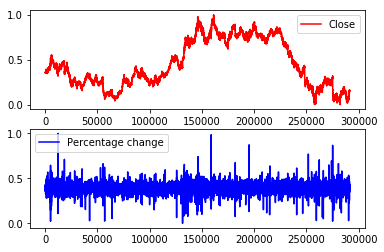

In [6]:
plot_stock(df)

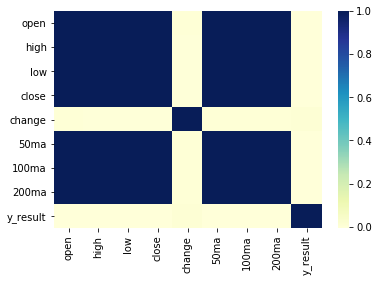

In [7]:
corr = df.corr()
ax = sns.heatmap(corr, cmap="YlGnBu")
plt.show()

In [8]:
def load_data(stock, seq_len):
    print ("Amount of features = {}".format(amount_of_features))
    data = stock.as_matrix()
    sequence_length = seq_len + 1 # index starting from 0
    x_result = []
    y_result = []
    for index in range(seq_len, len(data) ): # maxmimum date = lastest date - sequence length
        x_result.append(data[index-seq_len: index,:-1]) # index : index + 22days
        y_result.append(data[index ,amount_of_features]);

    #print('---', data[0])
    #print('---', x_result[0])
    #print('---', y_result[0])
    x_result = np.array(x_result)
    y_result = np.array(y_result)
    row = round(0.6 * y_result.shape[0]) # 80% split
    print ("Amount of training data = {}".format(0.9 * x_result.shape[0]))
    print ("Amount of testing data = {}".format(0.1 * y_result.shape[0]))
     
    X_train = x_result[:int(row), :] # 90% date
    y_train = y_result[:int(row)] # 90% date
        

    X_test = x_result[int(row):, :]
    y_test = y_result[int(row):]
    # filter for 1 and -1 for validation only
    X_test = X_test[y_test[:]!=0,:]
    y_test = y_test[y_test[:]!=0]
    #print(result.shape[0], len(y_result), int(row), y_result[int(row):])
    #X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], amount_of_features-1))
    #X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], amount_of_features-1))
    
    return [X_train, y_train, X_test, y_test]

In [9]:
lb = preprocessing.LabelBinarizer()
lb.fit([1, 0, -1])

X_tr, lab_tr, X_vld, lab_vld = load_data(df, seq_len)
y_tr = lb.transform(lab_tr)
y_vld = lb.transform(lab_vld)
print(X_tr.shape, lab_tr.shape, X_vld.shape, lab_vld.shape)
print(amount_of_features)

Amount of features = 8
Amount of training data = 261972.9
Amount of testing data = 29108.100000000002
(174649, 60, 8) (174649,) (70650, 60, 8) (70650,)
8


In [10]:
def get_batches(X, y, batch_size = 100):
	""" Return a generator for batches """
	n_batches = len(X) // batch_size
	X, y = X[:n_batches*batch_size], y[:n_batches*batch_size]

	# Loop over batches and yield
	for b in range(0, len(X), batch_size):
		yield X[b:b+batch_size], y[b:b+batch_size]

In [11]:
graph = tf.Graph()
n_channels = amount_of_features
n_classes = lb.transform([1]).shape[1]
# Construct placeholders
with graph.as_default():
    inputs_ = tf.placeholder(tf.float32, [None, seq_len, n_channels], name = 'inputs')
    labels_ = tf.placeholder(tf.float32, [None, n_classes], name = 'labels')
    keep_prob_ = tf.placeholder(tf.float32, name = 'keep')
    learning_rate_ = tf.placeholder(tf.float32, name = 'learning_rate')

Construct inputs to LSTM

In [12]:
with graph.as_default():
    # Construct the LSTM inputs and LSTM cells
    lstm_in = tf.transpose(inputs_, [1,0,2]) # reshape into (seq_len, N, channels)
    lstm_in = tf.reshape(lstm_in, [-1, n_channels]) # Now (seq_len*N, n_channels)
    
    # To cells
    lstm_in = tf.layers.dense(lstm_in, lstm_size, activation=None) # or tf.nn.relu, tf.nn.sigmoid, tf.nn.tanh?
    
    # Open up the tensor into a list of seq_len pieces
    lstm_in = tf.split(lstm_in, seq_len, 0)
    
    # Add LSTM layers
    lstm = tf.contrib.rnn.BasicLSTMCell(lstm_size)
    drop = tf.contrib.rnn.DropoutWrapper(lstm, output_keep_prob=keep_prob_)
    cell = tf.contrib.rnn.MultiRNNCell([drop] * lstm_layers)
    initial_state = cell.zero_state(batch_size, tf.float32)

Define forward pass, cost function and optimizer:

In [13]:
with graph.as_default():
    outputs, final_state = tf.contrib.rnn.static_rnn(cell, lstm_in, dtype=tf.float32,
                                                     initial_state = initial_state)
    
    # We only need the last output tensor to pass into a classifier
    logits = tf.layers.dense(outputs[-1], n_classes, name='logits')
    
    # Cost function and optimizer
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels_))
    #optimizer = tf.train.AdamOptimizer(learning_rate_).minimize(cost) # No grad clipping
    
    # Grad clipping
    train_op = tf.train.AdamOptimizer(learning_rate_)

    gradients = train_op.compute_gradients(cost)
    capped_gradients = [(tf.clip_by_value(grad, -1., 1.), var) for grad, var in gradients]
    optimizer = train_op.apply_gradients(capped_gradients)
    
    # Accuracy
    correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

In [14]:
if (os.path.exists('checkpoints') == False):
    !mkdir checkpoints

In [15]:
interation_compute_val = 1
validation_acc = []
validation_loss = []

train_acc = []
train_loss = []

with graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    iteration = 1
    
    for e in range(epochs):
        # Initialize 
        state = sess.run(initial_state)
        
        # Loop over batches
        for x,y in get_batches(X_tr, y_tr, batch_size):
            
            # Feed dictionary
            feed = {inputs_ : x, labels_ : y, keep_prob_ : 0.5, 
                    initial_state : state, learning_rate_ : learning_rate}
            
            loss, _ , state, acc = sess.run([cost, optimizer, final_state, accuracy], 
                                             feed_dict = feed)
            train_acc.append(acc)
            train_loss.append(loss)
            
            # Print at each 5 iters
            if (iteration % 5 == 0):
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Train loss: {:6f}".format(loss),
                      "Train acc: {:.6f}".format(acc))
            
            # Compute validation loss at every 25 iterations
            if (iteration%interation_compute_val == 50):
                
                # Initiate for validation set
                val_state = sess.run(cell.zero_state(batch_size, tf.float32))
                
                val_acc_ = []
                val_loss_ = []
                for x_v, y_v in get_batches(X_vld, y_vld, batch_size):
                    # Feed
                    feed = {inputs_ : x_v, labels_ : y_v, keep_prob_ : 1.0, initial_state : val_state}
                    
                    # Loss
                    loss_v, state_v, acc_v = sess.run([cost, final_state, accuracy], feed_dict = feed)
                    
                    val_acc_.append(acc_v)
                    val_loss_.append(loss_v)
                
                # Print info
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Validation loss: {:6f}".format(np.mean(val_loss_)),
                      "Validation acc: {:.6f}".format(np.mean(val_acc_)))
                
                # Store
                validation_acc.append(np.mean(val_acc_))
                validation_loss.append(np.mean(val_loss_))
            
            # Iterate 
            iteration += 1
    
    saver.save(sess,"checkpoints/har-lstm.ckpt")

Epoch: 0/20 Iteration: 5 Train loss: 1.215538 Train acc: 0.226562
Epoch: 0/20 Iteration: 10 Train loss: 1.092072 Train acc: 0.408203
Epoch: 0/20 Iteration: 15 Train loss: 1.126286 Train acc: 0.230469
Epoch: 0/20 Iteration: 20 Train loss: 1.054115 Train acc: 0.380859
Epoch: 0/20 Iteration: 25 Train loss: 1.126658 Train acc: 0.174805
Epoch: 0/20 Iteration: 30 Train loss: 1.096040 Train acc: 0.347656
Epoch: 0/20 Iteration: 35 Train loss: 1.073126 Train acc: 0.534180
Epoch: 0/20 Iteration: 40 Train loss: 1.016703 Train acc: 0.601562
Epoch: 0/20 Iteration: 45 Train loss: 1.004169 Train acc: 0.625000
Epoch: 0/20 Iteration: 50 Train loss: 1.084363 Train acc: 0.423828
Epoch: 0/20 Iteration: 55 Train loss: 1.109171 Train acc: 0.376953
Epoch: 0/20 Iteration: 60 Train loss: 1.155834 Train acc: 0.277344
Epoch: 0/20 Iteration: 65 Train loss: 0.968411 Train acc: 0.627930
Epoch: 0/20 Iteration: 70 Train loss: 1.090737 Train acc: 0.424805
Epoch: 0/20 Iteration: 75 Train loss: 1.155967 Train acc: 0.378

Epoch: 3/20 Iteration: 610 Train loss: 0.982188 Train acc: 0.653320
Epoch: 3/20 Iteration: 615 Train loss: 1.147089 Train acc: 0.282227
Epoch: 3/20 Iteration: 620 Train loss: 0.993323 Train acc: 0.612305
Epoch: 3/20 Iteration: 625 Train loss: 0.938693 Train acc: 0.709961
Epoch: 3/20 Iteration: 630 Train loss: 1.100820 Train acc: 0.402344
Epoch: 3/20 Iteration: 635 Train loss: 0.991327 Train acc: 0.600586
Epoch: 3/20 Iteration: 640 Train loss: 1.230196 Train acc: 0.157227
Epoch: 3/20 Iteration: 645 Train loss: 1.283179 Train acc: 0.057617
Epoch: 3/20 Iteration: 650 Train loss: 1.164767 Train acc: 0.210938
Epoch: 3/20 Iteration: 655 Train loss: 1.151009 Train acc: 0.220703
Epoch: 3/20 Iteration: 660 Train loss: 1.153515 Train acc: 0.111328
Epoch: 3/20 Iteration: 665 Train loss: 1.107995 Train acc: 0.330078
Epoch: 3/20 Iteration: 670 Train loss: 1.104179 Train acc: 0.255859
Epoch: 3/20 Iteration: 675 Train loss: 1.113980 Train acc: 0.239258
Epoch: 3/20 Iteration: 680 Train loss: 1.126119 

Epoch: 7/20 Iteration: 1210 Train loss: 1.104006 Train acc: 0.373047
Epoch: 7/20 Iteration: 1215 Train loss: 1.096731 Train acc: 0.335938
Epoch: 7/20 Iteration: 1220 Train loss: 1.102458 Train acc: 0.308594
Epoch: 7/20 Iteration: 1225 Train loss: 1.099520 Train acc: 0.296875
Epoch: 7/20 Iteration: 1230 Train loss: 1.085392 Train acc: 0.599609
Epoch: 7/20 Iteration: 1235 Train loss: 1.055715 Train acc: 0.625000
Epoch: 7/20 Iteration: 1240 Train loss: 1.092607 Train acc: 0.423828
Epoch: 7/20 Iteration: 1245 Train loss: 1.098295 Train acc: 0.376953
Epoch: 7/20 Iteration: 1250 Train loss: 1.132278 Train acc: 0.277344
Epoch: 7/20 Iteration: 1255 Train loss: 1.015590 Train acc: 0.627930
Epoch: 7/20 Iteration: 1260 Train loss: 1.091165 Train acc: 0.424805
Epoch: 7/20 Iteration: 1265 Train loss: 1.121977 Train acc: 0.378906
Epoch: 7/20 Iteration: 1270 Train loss: 0.990086 Train acc: 0.622070
Epoch: 7/20 Iteration: 1275 Train loss: 1.106495 Train acc: 0.370117
Epoch: 7/20 Iteration: 1280 Train 

Epoch: 10/20 Iteration: 1805 Train loss: 1.145778 Train acc: 0.282227
Epoch: 10/20 Iteration: 1810 Train loss: 0.994553 Train acc: 0.612305
Epoch: 10/20 Iteration: 1815 Train loss: 0.940494 Train acc: 0.709961
Epoch: 10/20 Iteration: 1820 Train loss: 1.100367 Train acc: 0.402344
Epoch: 10/20 Iteration: 1825 Train loss: 0.991849 Train acc: 0.600586
Epoch: 10/20 Iteration: 1830 Train loss: 1.227979 Train acc: 0.157227
Epoch: 10/20 Iteration: 1835 Train loss: 1.280854 Train acc: 0.057617
Epoch: 10/20 Iteration: 1840 Train loss: 1.164308 Train acc: 0.210938
Epoch: 10/20 Iteration: 1845 Train loss: 1.150776 Train acc: 0.220703
Epoch: 10/20 Iteration: 1850 Train loss: 1.154160 Train acc: 0.111328
Epoch: 10/20 Iteration: 1855 Train loss: 1.108026 Train acc: 0.331055
Epoch: 10/20 Iteration: 1860 Train loss: 1.103314 Train acc: 0.255859
Epoch: 10/20 Iteration: 1865 Train loss: 1.115031 Train acc: 0.239258
Epoch: 10/20 Iteration: 1870 Train loss: 1.124221 Train acc: 0.204102
Epoch: 11/20 Iterati

Epoch: 14/20 Iteration: 2395 Train loss: 1.086785 Train acc: 0.480469
Epoch: 14/20 Iteration: 2400 Train loss: 1.116976 Train acc: 0.359375
Epoch: 14/20 Iteration: 2405 Train loss: 1.088589 Train acc: 0.345703
Epoch: 14/20 Iteration: 2410 Train loss: 1.106389 Train acc: 0.300781
Epoch: 14/20 Iteration: 2415 Train loss: 1.107463 Train acc: 0.162109
Epoch: 14/20 Iteration: 2420 Train loss: 1.092497 Train acc: 0.590820
Epoch: 14/20 Iteration: 2425 Train loss: 1.078823 Train acc: 0.623047
Epoch: 14/20 Iteration: 2430 Train loss: 1.088508 Train acc: 0.423828
Epoch: 14/20 Iteration: 2435 Train loss: 1.090207 Train acc: 0.375977
Epoch: 14/20 Iteration: 2440 Train loss: 1.116785 Train acc: 0.277344
Epoch: 14/20 Iteration: 2445 Train loss: 1.027963 Train acc: 0.627930
Epoch: 14/20 Iteration: 2450 Train loss: 1.081765 Train acc: 0.424805
Epoch: 14/20 Iteration: 2455 Train loss: 1.096405 Train acc: 0.378906
Epoch: 14/20 Iteration: 2460 Train loss: 1.007981 Train acc: 0.622070
Epoch: 14/20 Iterati

Epoch: 17/20 Iteration: 2985 Train loss: 1.087033 Train acc: 0.416016
Epoch: 17/20 Iteration: 2990 Train loss: 0.983993 Train acc: 0.653320
Epoch: 17/20 Iteration: 2995 Train loss: 1.145570 Train acc: 0.282227
Epoch: 17/20 Iteration: 3000 Train loss: 0.994765 Train acc: 0.612305
Epoch: 17/20 Iteration: 3005 Train loss: 0.941023 Train acc: 0.709961
Epoch: 17/20 Iteration: 3010 Train loss: 1.100250 Train acc: 0.402344
Epoch: 17/20 Iteration: 3015 Train loss: 0.992079 Train acc: 0.600586
Epoch: 17/20 Iteration: 3020 Train loss: 1.227504 Train acc: 0.157227
Epoch: 17/20 Iteration: 3025 Train loss: 1.279919 Train acc: 0.057617
Epoch: 17/20 Iteration: 3030 Train loss: 1.164125 Train acc: 0.210938
Epoch: 17/20 Iteration: 3035 Train loss: 1.150874 Train acc: 0.220703
Epoch: 17/20 Iteration: 3040 Train loss: 1.153972 Train acc: 0.111328
Epoch: 17/20 Iteration: 3045 Train loss: 1.108135 Train acc: 0.327148
Epoch: 17/20 Iteration: 3050 Train loss: 1.103434 Train acc: 0.255859
Epoch: 17/20 Iterati

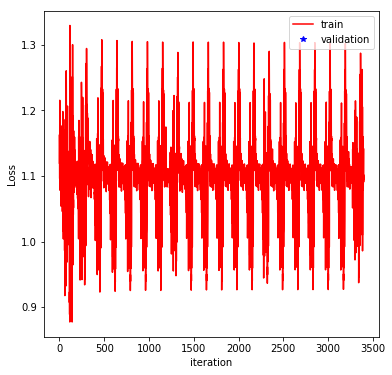

In [16]:
# Plot training and test loss
t = np.arange(iteration-1)

plt.figure(figsize = (6,6))
plt.plot(t, np.array(train_loss), 'r-', t[t % interation_compute_val == 50], np.array(validation_loss), 'b*')
plt.xlabel("iteration")
plt.ylabel("Loss")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

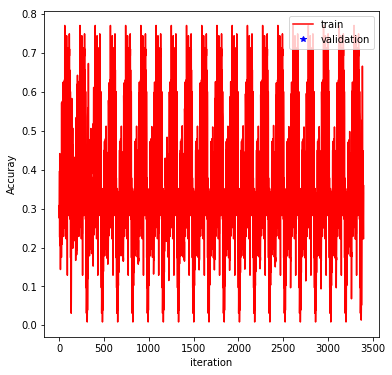

In [17]:

# Plot Accuracies# Plot A 
plt.figure(figsize = (6,6))

plt.plot(t, np.array(train_acc), 'r-', t[t % interation_compute_val == 50], validation_acc, 'b*')
plt.xlabel("iteration")
plt.ylabel("Accuray")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

Evaluate on test set

In [18]:
test_acc = []

with tf.Session(graph=graph) as sess:
    # Restore
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    test_state = sess.run(cell.zero_state(batch_size, tf.float32))
    print(y_vld.shape)
    for x_t, y_t in get_batches(X_vld, y_vld, batch_size):        
        feed = {inputs_: x_t,
                labels_: y_t,
                keep_prob_: 1,
                initial_state: test_state}
        
        batch_acc, test_state = sess.run([accuracy, final_state], feed_dict=feed)
        test_acc.append(batch_acc)
        print(batch_acc)
    print("Test accuracy: {:.6f}".format(np.mean(test_acc)))

INFO:tensorflow:Restoring parameters from checkpoints\har-lstm.ckpt
(70650, 3)
0.476563
0.589844
0.299805
0.452148
0.670898
0.546875
0.370117
0.469727
0.668945
0.486328
0.609375
0.336914
0.615234
0.332031
0.258789
0.666992
0.575195
0.395508
0.513672
0.682617
0.523438
0.46582
0.330078
0.580078
0.40918
0.551758
0.446289
0.59375
0.661133
0.574219
0.544922
0.546875
0.611328
0.5625
0.5
0.526367
0.521484
0.648438
0.583984
0.379883
0.501953
0.470703
0.575195
0.640625
0.592773
0.365234
0.723633
0.458008
0.443359
0.579102
0.472656
0.517578
0.426758
0.354492
0.641602
0.436523
0.604492
0.325195
0.736328
0.573242
0.553711
0.352539
0.579102
0.30957
0.533203
0.56543
0.700195
0.522461
Test accuracy: 0.516688


In [19]:

a = np.array([[ 0,  1,  2,  0,  4,  5,  6,  7,  8,  10],
              [ 0, 11,  0, 13,  0, 15,  0, 17, 18,  0]])
print (a[a.max(axis=1) >= 10])


[[ 0  1  2  0  4  5  6  7  8 10]
 [ 0 11  0 13  0 15  0 17 18  0]]


In [20]:

a = np.array([[ 0,  1,  2,  0,  4,  5,  6,  7,  8,  9],
              [ 0, 11,  0, 13,  0, 15,  0, 17, 18,  0]])
print (a[a[:,2]!=0])

[[0 1 2 0 4 5 6 7 8 9]]


In [21]:
print(ytest[:]!=0)
Xtest = np.array([[ 0,  1,  2,  0,  4,  5,  6,  7,  8,  9],
              [ 0, 11,  0, 13,  0, 15,  0, 17, 18,  0],
             [ 0, 11,  0, 13,  0, 15,  0, 11, 1,  1]])
ytest = np.array([ 0,  1,  1])
Xtest = Xtest[ytest[:]!=0,:]
ytest = ytest[ytest[:]!=0]
print(Xtest)
print(ytest)

NameError: name 'ytest' is not defined